<a href="https://colab.research.google.com/github/sainikhilvenkata/Playground/blob/master/CAM%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [ ]:

def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(last_conv_layer_output, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap



In [ ]:

%mkdir templates -p

In [ ]:
%%writefile templates/index.html
<!doctype html>
<html lang="en">

<html>
<style>
.header {
  padding: 60px;
  text-align: center;
  background: #1abc9c;
  color: white;
  font-size: 30px;
}

.button {
  background-color: darkblue;
  border: none;
  color: white;
  padding: 15px 32px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;
  margin: 4px 2px;
  cursor: pointer;
}

.footer {
   position: fixed;
   left: 0;
   bottom: 0;
   width: 100%;
   background-color: darkblue;
   color: white;
   text-align: center;
   font-size: 18px;
   
}

hr.new4 {
  border-top: 5px solid darkblue;
}
</style>
<head>
 <title>CAM Model</title>
</head>

<body>

<div style="display: flex">
<img src="https://www.sastra.edu/virtual_class/images/sastralogo.png" alt="alternatetext" width="28%" height="4%">
<div style="margin-left: 19%;margin-top: 3%"><h1>MINI PROGECT GUI</h1></div>
</div>
<hr class="new4">
<h1 style="margin-left: 10%">A Mutual Bootstrapping Model for Automated Skin Lesion Segmentation and Classification
</h1>

<div style="color: darkblue;font-size: 20px;">
<p style="float: right;font-weight: bold;" > Guided By : Premladha J</p>
<p style="font-weight: bold;">Done By :</p>
  <ol>
	<li>Aditya Gattu</li>
	<li>Vagicherla Sai Nikhil</li>
	<li> Uppalapati Saketh</li>
  </ol>
</div>

    <h3 style="text-align: center;color: darkblue;font-size: 23px">Upload your skin lesion image for CAM Model generation</h3>
    <div style="text-align: center">

    <form  action = "/success" method ='post' enctype=multipart/form-data>
      <input type="file" name="file" >
      <input type="submit" value="Upload image" class="button" onclick="initImageUpload()" />
      <a id="aDownload">
    </div>
    
     <div class="footer">
        <p>Sastra Deemed to be University</p>
    </div>
    <script>
    function initImageUpload() {
        var file = uploadFile.files[0];
        var a = document.getElementById('aDownload');
        a.href = file.name;

        var ext = file.name.split('.').pop();
        var filename = file.name.substring(0, file.name.lastIndexOf('.'));
          var newFileName = "new" + "." + ext;//provide the new name here

        a.setAttribute("download", newFileName);
        a.click();
    }
    </script>
</body>
</html>



Overwriting templates/index.html


In [ ]:
%%writefile templates/result.html
<!doctype html>
<html lang="en">
<style>
.header {
  padding: 60px;
  text-align: center;
  background: #1abc9c;
  color: white;
  font-size: 30px;
}
.footer {
   position: fixed;
   left: 0;
   bottom: 0;
   width: 100%;
   background-color: darkblue;
   color: white;
   text-align: center;
   font-size: 18px;
   
}
hr.new4 {
  border-top: 5px solid darkblue;
}
</style>
<html>
<head>
 <title>Skin</title>
</head>
<body>

<div style="display: flex">
<img src="https://www.sastra.edu/virtual_class/images/sastralogo.png" alt="alternatetext" width="28%" height="4%">
<div style="margin-left: 19%;margin-top: 3%"><h1>MINI PROGECT GUI</h1></div>
</div>
<hr class="new4">
<h1 style="margin-left: 20%">Output For Cam Model
</h1>
<p style="margin-left: 30%">
 <img src="static/final image.jpg">
 
</p>
<div class="footer">
        <p>Sastra Deemed to be University</p>
    </div>
</body>
</html>

Overwriting templates/result.html


In [ ]:
!pip install flask-ngrok

In [ ]:
mkdir static

mkdir: cannot create directory ‘static’: File exists


In [ ]:
from flask_ngrok import run_with_ngrok

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://fc2ca12a8a51.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [29/Dec/2020 06:56:10] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [29/Dec/2020 06:56:11] "GET /favicon.ico HTTP/1.1" 404 -


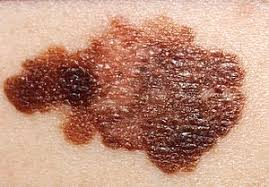

Predicted: [('n01776313', 'tick', 0.43184558)]


127.0.0.1 - - [29/Dec/2020 06:56:25] "POST /success HTTP/1.1" 200 -
127.0.0.1 - - [29/Dec/2020 06:56:26] "GET /static/final%20image.jpg HTTP/1.1" 200 -


<Figure size 432x288 with 0 Axes>

In [ ]:
from flask import Flask, render_template, url_for,request
import os

PEOPLE_FOLDER = os.path.join('content','static')

app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = PEOPLE_FOLDER

run_with_ngrok(app)


@app.route("/",methods=['GET', 'POST'])
@app.route("/home")
def home():
  if request.method == 'GET':
    try:
      return render_template('index.html')
    except Exception as e:
      return str(e)

@app.route('/success', methods = ['POST'])  
def success():  
    if request.method == 'POST':  
        f = request.files['file']  
        f.save(f.filename)   
        model_builder = keras.applications.xception.Xception
        img_size = (299, 299)
        preprocess_input = keras.applications.xception.preprocess_input
        decode_predictions = keras.applications.xception.decode_predictions

        last_conv_layer_name = "block14_sepconv2_act"
        classifier_layer_names = [
          "avg_pool",
            "predictions",
              ] 
        img_path='/content/1.jpg'
        display(Image(img_path))
        img_array = preprocess_input(get_img_array(img_path, size=img_size))

        model = model_builder(weights="imagenet")

        preds = model.predict(img_array)
        print("Predicted:", decode_predictions(preds, top=1)[0])

        heatmap = make_gradcam_heatmap(
        img_array, model, last_conv_layer_name, classifier_layer_names
        )
        plt.savefig('/content/static/heatmap.jpg')
        #plt.matshow(heatmap)
        #plt.show()
        img = keras.preprocessing.image.load_img(img_path)
        img = keras.preprocessing.image.img_to_array(img)

        heatmap = np.uint8(255 * heatmap)

        jet = cm.get_cmap("jet")

        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

        superimposed_img = jet_heatmap * 1 + img
        superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

        save_path = "/content/static/final image.jpg"
        superimposed_img.save(save_path)

        #display(Image(save_path))


        full_filename = os.path.join(app.config['UPLOAD_FOLDER'], 'final image.jpg')
        #full_filename1 = os.path.join(app.config['UPLOAD_FOLDER'], 'heatmap.jpg')
        


    return render_template('result.html',user_image = full_filename, name = f.filename)


@app.route("/about")
def about():
    return "<h1>Hello ncksdnWorld</h1>"



app.run()